# Complexation

##### Germain Vallverdu [germain.vallverdu@univ-pau.fr](germain.vallverdu@univ-pau.fr)

## Python set up

In [23]:
%pylab --no-import-all inline
from scipy.optimize import fsolve
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")

Populating the interactive namespace from numpy and matplotlib


## Equations

This is the system of equations we want to solve :

\begin{align*}
    K_{d_{app}, 2} & = \frac{[B]^2[L^-]^7}{[C]} &
    K_{d_{app}, 3} & = \frac{[B]^2[L^-]^5}{[D]} &
    K_{d_{app}, 4} & = \frac{[B]^2[L^-]^3}{[E]}
\end{align*}

\begin{align*}
    [Cr_{tot}] & = [B] + 2[C] + 2[D] + 2[E] \\
    [L_{tot}] & = [L] + 3[E] + 5[D] + 7[C] + [HL]
\end{align*}

with $Ka = [L^-][H^+] \,/\,[LH]$ you get

\begin{align}
    [Cr]_{tot} & = [B] + 2[C] + 2[D] + 2[E] \\
    [L^-]_{tot} & = \left(1 + \frac{[H^+]}{Ka}\right)[L^-] + 3[E] + 5[D] + 7[C]
\end{align}

One can reduce the system to 2 equations with 2 unknowns using :

\begin{align*}
    [C] & = \frac{[B]^2[L^-]^7}{K_{d_{app}, 2}} &
    [D] & = \frac{[B]^2[L^-]^5}{K_{d_{app}, 3}} &
    [E] & = \frac{[B]^2[L^-]^3}{K_{d_{app}, 4}}
\end{align*}

Now equations of $[Cr]_{tot}$ and $[L^-]_{tot}$ reads 

\begin{align}
    [Cr]_{tot} & = [B] + 2\frac{[B]^2[L^-]^7}{K_{d_{app}, 2}}  
                       + 2\frac{[B]^2[L^-]^5}{K_{d_{app}, 3}} 
                       + 2\frac{[B]^2[L^-]^3}{K_{d_{app}, 4}} \\
    [L^-]_{tot} & = \left(1 + \frac{[H^+]}{Ka}\right)[L^-] + 3\frac{[B]^2[L^-]^3}{K_{d_{app}, 4}} 
                                                           + 5\frac{[B]^2[L^-]^5}{K_{d_{app}, 3}} 
                                                           + 7\frac{[B]^2[L^-]^7}{K_{d_{app}, 2}}
\end{align}

we have only 2 unknowns, $[B]$ and $[L^-]$, and we will solve the following system :

\begin{equation}
    \begin{cases}
    [B] + 2\dfrac{[B]^2[L^-]^7}{K_{d_{app}, 2}}  
        + 2\dfrac{[B]^2[L^-]^5}{K_{d_{app}, 3}} 
        + 2\dfrac{[B]^2[L^-]^3}{K_{d_{app}, 4}} - [Cr]_{tot} & = 0 \\
    \left(1 + \dfrac{[H^+]}{Ka}\right)[L^-] + 3\dfrac{[B]^2[L^-]^3}{K_{d_{app}, 4}} 
                                           + 5\dfrac{[B]^2[L^-]^5}{K_{d_{app}, 3}} 
                                           + 7\dfrac{[B]^2[L^-]^7}{K_{d_{app}, 2}} - [L^-]_{tot} & = 0
    \end{cases}
\end{equation}

## Data

pH, Ka, $[Cr]_{tot}$ and $[L^-]_{tot}$ are fixed quantities with the following ranges :

* $[Cr]_{tot} \in [0.1 ; 0.8]$
* $[L^-]_{tot} \in [0.1 ; 0.8]$
* $pH \in [1 ; 6]$
* pKa = 3.5 

Dissociative constants are

\begin{align*}
    K_{d_{app}, 2} & = 6.15\times 10^{-7} &
    K_{d_{app}, 3} & = 3.9\times 10^{-5} &
    K_{d_{app}, 4} & = 2.14\times 10^{-2.4}
\end{align*}

## Computations

### Basic functions

First defines basic functions

In [2]:
def cH(pH):
    """ compute [H+] from pH """
    return 10**(-pH)

def get_c_cplx(B, L, n, Kd):
    """ compute concentration of complex CLn associated to constant Kd """
    return B**2 * L**n / Kd

def output_results(B, L, params):
    Kd2, Kd3, Kd4, pH, Ka, Cr_tot, L_tot = params
    # compute C, D, E from B, L
    C = get_c_cplx(B, L, 7, Kd2)
    D = get_c_cplx(B, L, 5, Kd3)
    E = get_c_cplx(B, L, 3, Kd4)
    # print results
    print("Cr3+ free = %10.4e " % B)
    print("L- free   = %10.4e " % L)
    print("Cr2L3^3+  = %10.4e " % C)
    print("Cr2L5^+   = %10.4e " % D) 
    print("Cr2L7^-   = %10.4e " % E)
    

### Set up constants

In [3]:
Kd2 = 6.15e-7
Kd3 = 3.9e-5
Kd4 = 2.14* 10**(-2.4)
Ka = 10**(-3.5)

### Equations to solve

In [4]:
def system(X, *params):
    """ 
    compute each equation of the system 
    
    Args:
        X is the unknowns
        params are the parameters 
    
    """
    B, L = X
    Kd2, Kd3, Kd4, pH, Ka, Cr_tot, L_tot = params
    
    # compute C, D, E from B, L
    C = get_c_cplx(B, L, 7, Kd2)
    D = get_c_cplx(B, L, 5, Kd3)
    E = get_c_cplx(B, L, 3, Kd4)
    
    # compute equations
    eq1 = B + 2 * C + 2 * D + 2 * E - Cr_tot
    eq2 = (1 + cH(pH) / Ka) * L + 3 * E + 5 * D + 7 * C - L_tot
    
    return (eq1, eq2)

### Solve the equations

#### set up parameters

In [5]:
Cr_tot = .4
L_tot = .4
pH = 4.5
params = (Kd2, Kd3, Kd4, pH, Ka, Cr_tot, L_tot)

#### define an estimate of B and L

In [ ]:
B = 5e-6
L = 3

#### run the solver

In [6]:
B, L = fsolve(system, x0=[1, 1], args=params)

In [7]:
output_results(B, L, params)

Cr3+ free = 2.9086e-01 
L- free   = 1.0361e-01 
Cr2L3^3+  = 1.7630e-02 
Cr2L5^+   = 2.5898e-02 
Cr2L7^-   = 1.1044e-02 


### Compute some datas

In [ ]:
pH = np.arange(1, 6.5, .5)
npts = len(pH)
df = pd.DataFrame({"Cr3+": npts * [.4]}, index=pH)
df.index.name = "pH"
df

In [31]:
data = {"pH": [], "Cr_tot": [], "L_tot": [], "Cr3+": [], "L-": [], "Cr2L3": [], "Cr2L5": [], "Cr2L7":[]}
Cr_tot = .2
L_tot = 8
for pH in np.arange(1, 6.5, .5):
    params = (Kd2, Kd3, Kd4, pH, Ka, Cr_tot, L_tot)
    B, L = fsolve(system, x0=[1e-6, L_tot], args=params)
    data["pH"].append(pH)
    data["Cr_tot"].append(Cr_tot)
    data["L_tot"].append(L_tot)
    data["Cr3+"].append(B)
    data["L-"].append(L)
    data["Cr2L3"].append(get_c_cplx(B, L, 3, Kd4))
    data["Cr2L5"].append(get_c_cplx(B, L, 5, Kd3))
    data["Cr2L7"].append(get_c_cplx(B, L, 7, Kd2))

In [32]:
df = pd.DataFrame(data)
df.set_index("pH", inplace=True)
df

,Cr2L3,Cr2L5,Cr2L7,Cr3+,Cr_tot,L-,L_tot
pH,,,,,,,
1.0,7.516391e-05,0.000010,4.210777e-07,1.998279e-01,0.2,0.025218,8
1.5,2.043559e-03,0.002781,1.098926e-03,1.881523e-01,0.2,0.078933,8
2.0,1.644939e-03,0.018810,6.244154e-02,3.420680e-02,0.2,0.228795,8
2.5,3.553287e-05,0.003428,9.602829e-02,1.015513e-03,0.2,0.664596,8
3.0,7.584439e-07,0.000510,9.947215e-02,3.460022e-05,0.2,1.754122,8
3.5,4.061736e-08,0.000118,9.988041e-02,2.667482e-06,0.2,3.650123,8
4.0,7.625095e-09,0.000051,9.994845e-02,6.170672e-07,0.2,5.546232,8
4.5,3.720207e-09,0.000036,9.996404e-02,3.292977e-07,0.2,6.636430,8
5.0,2.878068e-09,0.000031,9.996838e-02,2.630564e-07,0.2,7.076292,8


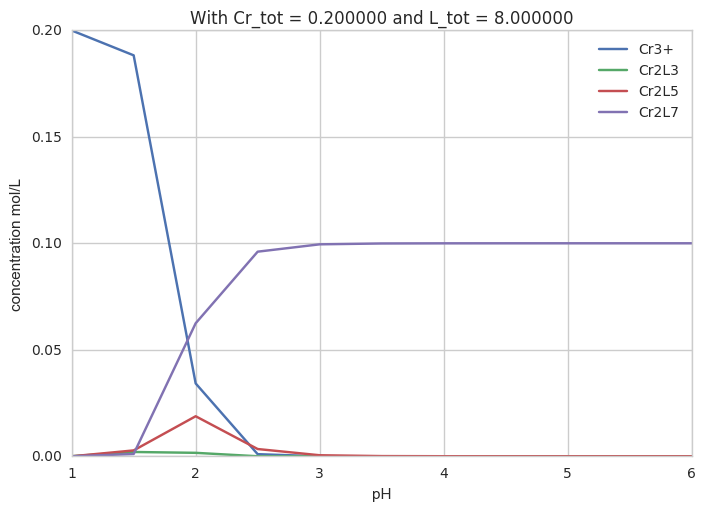

In [38]:
ax = df[["Cr3+", "Cr2L3", "Cr2L5", "Cr2L7"]].plot(
    kind="line", 
    title="With Cr_tot = %f and L_tot = %f" % (Cr_tot, L_tot),    
)
ax.set_xlabel("pH")
ax.set_ylabel("concentration mol/L")

In [10]:
data = {"pH": [], "Cr_tot": [], "L_tot": [], "Cr3+": [], "L-": [], "Cr2L3": [], "Cr2L5": [], "Cr2L7":[]}
for pH in np.arange(1, 6.5, .5):
    for Cr_tot in np.arange(0.1, 0.9, .1):
        for L_tot in np.arange(0.1, 8.1, .1):
            params = (Kd2, Kd3, Kd4, pH, Ka, Cr_tot, L_tot)
            B, L = fsolve(system, x0=[.1, .1], args=params)
            data["pH"].append(pH)
            data["Cr_tot"].append(Cr_tot)
            data["L_tot"].append(L_tot)
            data["Cr3+"].append(B)
            data["L-"].append(L)
            data["Cr2L3"].append(get_c_cplx(B, L, 3, Kd4))
            data["Cr2L5"].append(get_c_cplx(B, L, 5, Kd3))
            data["Cr2L7"].append(get_c_cplx(B, L, 7, Kd2))

/Users/gvallver/anaconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/gvallver/anaconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


## Make a plot